In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0604/weights_KD_segformer_0604_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.7
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 615ms/step - loss: 0.0056
Average validation loss: 0.6831516623497009
4/4 [==============================] - 6s 629ms/step - loss: 0.0056 - val_loss: 0.6832
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 618ms/step - loss: 0.0036 - val_loss: 0.6832
Average validation loss: 0.612394392490387
4/4 [==============================] - 8s 633ms/step - loss: 0.0036 - val_loss: 0.6478
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 11s 607ms/step - loss: 0.0026 - val_loss: 0.6478
Average validation loss: 0.4884246587753296
4/4 [==============================] - 11s 620ms/step - loss: 0.0026 - val_loss:

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 696ms/step - loss: 6.2983e-07
Average validation loss: 0.0011206476483494043
8/8 [==============================] - 6s 705ms/step - loss: 6.2983e-07 - val_loss: 0.0011
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 690ms/step - loss: 6.0492e-07 - val_loss: 0.0011
Average validation loss: 0.00386857520788908
8/8 [==============================] - 11s 703ms/step - loss: 6.0492e-07 - val_loss: 0.0025
Epoch 3/10
8/8 [==============================] - 17s 705ms/step - loss: 6.0577e-07 - val_loss: 0.0025
Average validation loss: 0.0037308494793251157
8/8 [==============================] - 17s 716ms/step - loss: 6.0577e-07 - val_loss: 0.0029
Epoch 4/10
8/8 [==============================] - 23s 701ms/step - loss: 6.0369e-07 - val_loss: 0.0029
Average validation loss: 0.00

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 690ms/step - loss: 1.6485e-06
Average validation loss: 0.04824306877950827
12/12 [==============================] - 8s 703ms/step - loss: 1.6485e-06 - val_loss: 0.0482
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 675ms/step - loss: 1.5257e-06 - val_loss: 0.0482
Average validation loss: 0.027470100360612076
12/12 [==============================] - 17s 687ms/step - loss: 1.5257e-06 - val_loss: 0.0379
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 25s 693ms/step - loss: 1.5195e-06 - val_loss: 0.0379
Average validation loss: 0.028179545576373737
12/12 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 704ms/step - loss: 6.8342e-07
Average validation loss: 0.04165769089013338
16/16 [==============================] - 11s 715ms/step - loss: 6.8342e-07 - val_loss: 0.0417
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 713ms/step - loss: 6.6733e-07 - val_loss: 0.0417
Average validation loss: 0.048604112525936216
16/16 [==============================] - 23s 724ms/step - loss: 6.6733e-07 - val_loss: 0.0451
Epoch 3/10
16/16 [==============================] - 35s 733ms/step - loss: 6.4279e-07 - val_loss: 0.0451
Average validation loss: 0.03688940993743017
16/16 [==============================] - 35s 744ms/step - loss: 6.4279e-07 - val_loss: 0.0424
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/wei

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 712ms/step - loss: 3.7957e-07
Average validation loss: 0.0723859965801239
20/20 [==============================] - 15s 722ms/step - loss: 3.7957e-07 - val_loss: 0.0724
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 701ms/step - loss: 3.5574e-07 - val_loss: 0.0724
Average validation loss: 0.07828771434724331
20/20 [==============================] - 29s 711ms/step - loss: 3.5574e-07 - val_loss: 0.0753
Epoch 3/10
20/20 [==============================] - 43s 721ms/step - loss: 3.4474e-07 - val_loss: 0.0753
Average validation loss: 0.0706865007057786
20/20 [==============================] - 43s 731ms/step - loss: 3.4474e-07 - val_loss: 0.0738
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weight

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 718ms/step - loss: 7.0041e-07
Average validation loss: 0.06013090722262859
24/24 [==============================] - 18s 729ms/step - loss: 7.0041e-07 - val_loss: 0.0601
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 34s 698ms/step - loss: 5.8081e-07 - val_loss: 0.0601
Average validation loss: 0.05986960045993328
24/24 [==============================] - 35s 709ms/step - loss: 5.8081e-07 - val_loss: 0.0600
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 51s 696ms/step - loss: 5.2423e-07 - val_loss: 0.0600
Average validation loss: 0.0588188786059618
24/24 [==============================] - 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 28s 704ms/step - loss: 1.4145e-06
Average validation loss: 0.06941362023353577
40/40 [==============================] - 29s 714ms/step - loss: 1.4145e-06 - val_loss: 0.0694
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 57s 711ms/step - loss: 1.1901e-06 - val_loss: 0.0694
Average validation loss: 0.13960140943527222
40/40 [==============================] - 58s 721ms/step - loss: 1.1901e-06 - val_loss: 0.1045
Epoch 3/10
40/40 [==============================] - 86s 706ms/step - loss: 1.1267e-06 - val_loss: 0.1045
Average validation loss: 0.09342590346932411
40/40 [==============================] - 86s 716ms/step - loss: 1.1267e-06 - val_loss: 0.1008
Epoch 4/10
40/40 [==============================] - 115s 715ms/step - loss: 1.0242e-06 - val_loss: 0.1008
Average validati

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 711ms/step - loss: 5.1372e-07
Average validation loss: 0.057359990663826466
48/48 [==============================] - 35s 721ms/step - loss: 5.1372e-07 - val_loss: 0.0574
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 69s 709ms/step - loss: 3.9744e-07 - val_loss: 0.0574
Average validation loss: 0.07158831817408402
48/48 [==============================] - 69s 720ms/step - loss: 3.9744e-07 - val_loss: 0.0645
Epoch 3/10
48/48 [==============================] - 103s 706ms/step - loss: 3.1943e-07 - val_loss: 0.0645
Average validation loss: 0.06634970350811879
48/48 [==============================] - 104s 716ms/step - loss: 3.1943e-07 - val_loss: 0.0651
Epoch 4/10
48/48 [==============================] - 138s 719ms/step - loss: 2.7604e-07 - val_loss: 0.0651
Average valid

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 715ms/step - loss: 6.8447e-07
Average validation loss: 0.09257654825757657
56/56 [==============================] - 41s 725ms/step - loss: 6.8447e-07 - val_loss: 0.0926
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 81s 718ms/step - loss: 4.6043e-07 - val_loss: 0.0926
Average validation loss: 0.08056166681594082
56/56 [==============================] - 81s 728ms/step - loss: 4.6043e-07 - val_loss: 0.0866
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 121s 711ms/step - loss: 3.6742e-07 - val_loss: 0.0866
Average validation loss: 0.061161016912332604
56/56 [==============================]

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 721ms/step - loss: 3.9467e-07
Average validation loss: 0.07811178610427305
64/64 [==============================] - 47s 731ms/step - loss: 3.9467e-07 - val_loss: 0.0781
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 92s 709ms/step - loss: 2.7736e-07 - val_loss: 0.0781
Average validation loss: 0.06486419308930635
64/64 [==============================] - 93s 719ms/step - loss: 2.7736e-07 - val_loss: 0.0715
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 138s 706ms/step - loss: 2.1693e-07 - val_loss: 0.0715
Average validation loss: 0.06346114387270063
64/64 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 51s 710ms/step - loss: 4.3877e-07
Average validation loss: 0.07296341988775465
72/72 [==============================] - 52s 720ms/step - loss: 4.3877e-07 - val_loss: 0.0730
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 103s 706ms/step - loss: 2.6366e-07 - val_loss: 0.0730
Average validation loss: 0.06105492522733079
72/72 [==============================] - 103s 716ms/step - loss: 2.6366e-07 - val_loss: 0.0670
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 155s 713ms/step - loss: 1.9762e-07 - val_loss: 0.0670
Average validation loss: 0.060584768342475094
72/72 [=============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 57s 710ms/step - loss: 5.0129e-07
Average validation loss: 0.06834879796952009
80/80 [==============================] - 58s 720ms/step - loss: 5.0129e-07 - val_loss: 0.0683
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 114s 707ms/step - loss: 3.0286e-07 - val_loss: 0.0683
Average validation loss: 0.05073531251400709
80/80 [==============================] - 115s 718ms/step - loss: 3.0286e-07 - val_loss: 0.0595
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 172s 710ms/step - loss: 2.2632e-07 - val_loss: 0.0595
Average validation loss: 0.047860675398260354
80/80 [===========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 68s 708ms/step - loss: 8.5271e-07
Average validation loss: 0.09016750714120765
96/96 [==============================] - 69s 718ms/step - loss: 8.5271e-07 - val_loss: 0.0902
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 137s 708ms/step - loss: 6.1361e-07 - val_loss: 0.0902
Average validation loss: 0.08376869303174317
96/96 [==============================] - 138s 718ms/step - loss: 6.1361e-07 - val_loss: 0.0870
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 206s 708ms/step - loss: 4.5650e-07 - val_loss: 0.0870
Average validation loss: 0.07328156050061807
96/96 [============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 85s 706ms/step - loss: 4.0697e-07
Average validation loss: 0.07504720184952021
120/120 [==============================] - 86s 716ms/step - loss: 4.0697e-07 - val_loss: 0.0750
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 171s 707ms/step - loss: 2.8278e-07 - val_loss: 0.0750
Average validation loss: 0.07339084847675016
120/120 [==============================] - 172s 717ms/step - loss: 2.8278e-07 - val_loss: 0.0742
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 257s 704ms/step - loss: 2.2025e-07 - val_loss: 0.0742
Average validation loss: 0.0714251241258656
120/120 [=================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 102s 707ms/step - loss: 3.0855e-07
Average validation loss: 0.06758243718650192
144/144 [==============================] - 103s 717ms/step - loss: 3.0855e-07 - val_loss: 0.0676
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 205s 709ms/step - loss: 2.1658e-07 - val_loss: 0.0676
Average validation loss: 0.05279939322887609
144/144 [==============================] - 207s 719ms/step - loss: 2.1658e-07 - val_loss: 0.0602
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 309s 707ms/step - loss: 1.7350e-07 - val_loss: 0.0602
Average validation loss: 0.06989486401693688
144/144 [==============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 113s 705ms/step - loss: 1.2850e-07
Average validation loss: 0.07068233861064073
160/160 [==============================] - 114s 715ms/step - loss: 1.2850e-07 - val_loss: 0.0707
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 227s 706ms/step - loss: 1.0352e-07 - val_loss: 0.0707
Average validation loss: 0.067424949206179
160/160 [==============================] - 229s 716ms/step - loss: 1.0352e-07 - val_loss: 0.0691
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 343s 710ms/step - loss: 8.7453e-08 - val_loss: 0.0691
Average validation loss: 0.07475164985808078
160/160 [================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 141s 707ms/step - loss: 8.1009e-07
Average validation loss: 0.06640724869794212
200/200 [==============================] - 143s 716ms/step - loss: 8.1009e-07 - val_loss: 0.0664
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 285s 707ms/step - loss: 5.1509e-07 - val_loss: 0.0664
Average validation loss: 0.06803773960797116
200/200 [==============================] - 287s 717ms/step - loss: 5.1509e-07 - val_loss: 0.0672
Epoch 3/10
200/200 [==============================] - 429s 709ms/step - loss: 3.8158e-07 - val_loss: 0.0672
Average validation loss: 0.05553620114456862
200/200 [==============================] - 430s 719ms/step - loss: 3.8158e-07 - val_loss: 0.0633
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:07 - loss: 1.1624e-06

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 170s 707ms/step - loss: 3.4380e-07
Average validation loss: 0.07989195660144711
240/240 [==============================] - 172s 717ms/step - loss: 3.4380e-07 - val_loss: 0.0799
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 342s 707ms/step - loss: 2.4046e-07 - val_loss: 0.0799
Average validation loss: 0.07504487077627951
240/240 [==============================] - 344s 717ms/step - loss: 2.4046e-07 - val_loss: 0.0775
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 514s 709ms/step - loss: 1.8472e-07 - val_loss: 0.0775
Average validation loss: 0.08219838682562113
240/240 [==============

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.08565614555263892, 0.030878759094921406, 0.05154463351985517, 0.0644983818847686, 0.06709094826504587, 0.05812942890139918, 0.07631213036179543, 0.06144957278001433, 0.06370689697430602, 0.05870386033551767, 0.05187534445741524, 0.04900357921642717, 0.06967333737130199, 0.061114632076758414, 0.053390833405008185, 0.048488409771205616, 0.054751782959402764, 0.06074280061284662]
std_val_losses =  [0.15062798899842766, 0.0204101607796767, 0.02048179675728322, 0.018103851311032496, 0.010410669393783432, 0.018942794120114216, 0.019760546297092115, 0.012705181302740487, 0.015884511402619355, 0.011856741971486586, 0.011238670031819224, 0.008838510633081071, 0.014221726113161559, 0.015593473763042808, 0.0099891641122604, 0.010346450207012806, 0.009258390723209, 0.012689281080649055]


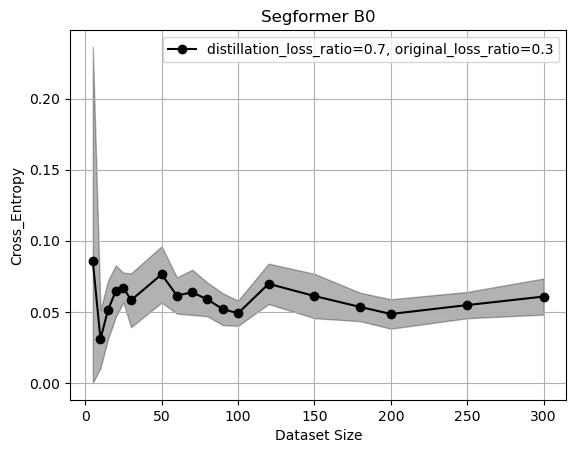

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0604')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.png"))

plt.show()